In [1]:
import os
import sys
import random
sys.path.append('../')

import lovely_tensors as lt
lt.monkey_patch()

import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps')

In [185]:
import torch
from torchvision import datasets, transforms

class MNIST_Dataset():
    def __init__(self, root_path):
        self.data_mean = torch.tensor([0.1307])
        self.data_stddev = torch.tensor([0.5])


        self.train_dataset = datasets.MNIST(root=root_path, train=True, download=True,
                                            transform=self.train_transform())
        self.test_dataset = datasets.MNIST(root=root_path, train=False, download=True,
                                           transform=self.test_transform())

    def train_transform(self):
        return transforms.Compose(
            [
                transforms.RandomCrop(32, padding=4),
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize(self.data_mean, self.data_stddev),
            ]
        )

    def test_transform(self):
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((64, 64)),
            transforms.Normalize(self.data_mean, self.data_stddev),
        ])

    def renormalize(self, x):
        x = x.clone()
        if x.shape[0] == 1:
            sh = x.shape[1:]
            x = x.reshape(1, -1).T
            x = x.reshape(*sh, 1)
        x *= self.data_stddev
        x += self.data_mean
        return torch.clip(x, 0, 1)

    
class CIFAR10_Dataset():
    def __init__(self, root_path):
        self.data_mean = torch.tensor([0.4914, 0.4822, 0.4465])
        self.data_stddev = torch.tensor([0.5, 0.5, 0.5])

        self.train_dataset = datasets.CIFAR10(root=root_path, train=True, download=True,
                                              transform=self.train_transform())
        self.test_dataset = datasets.CIFAR10(root=root_path, train=False, download=True,
                                             transform=self.test_transform())

    def train_transform(self):
        return transforms.Compose(
            [
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize(self.data_mean, self.data_stddev),
            ]
        )

    def test_transform(self):
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((64, 64)),
            transforms.Normalize(self.data_mean, self.data_stddev),
        ])

    def renormalize(self, x):
        x = x.clone()
        if x.shape[0] == 3:
            sh = x.shape[1:]
            x = x.reshape(3, -1).T
            x = x.reshape(*sh, 3)
        x *= self.data_stddev
        x += self.data_mean
        return torch.clip(x, 0, 1)
            
    
root_path = "/Users/lfbarba/GitHub/data"
cifar = CIFAR10_Dataset(root_path)

Files already downloaded and verified
Files already downloaded and verified


In [186]:
from chip.utils.diffusion_process import DiffusionProcess
from chip.datasets.diffusion_dataset import DiffusionDS

dp = DiffusionProcess(T=1000)
trainSet = DiffusionDS(cifar.train_dataset, diffusion_process=dp)
testSet = DiffusionDS(cifar.test_dataset, diffusion_process=dp)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor i32 759


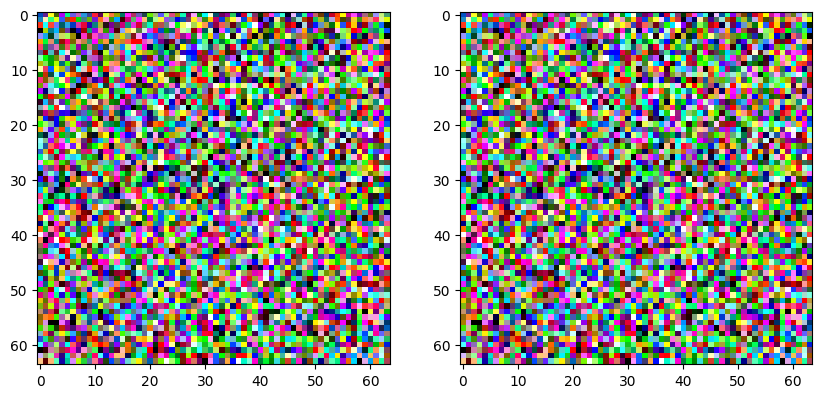

In [163]:
x_t, epsilon, t = trainSet[0]
print(t)
fig, ((ax1, ax2))  = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(cifar.renormalize(x_t))
ax2.imshow(cifar.renormalize(epsilon))

In [164]:
from chip.models.diffusion_model import UNetDiffusionModel

def load_model(model, model_path):
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"model loaded from checkpoint {model_path}")

model = UNetDiffusionModel(
        image_channels=3,
        n_channels=64,
        ch_mults=[1, 2, 2, 4],
        is_attn=[False, False, False, True],
    ).to(device)
model_path = f"../checkpoints/diffusion_model_cifar.pt"    
load_model(model, model_path)
model.eval()

model loaded from checkpoint ../checkpoints/diffusion_model_cifar.pt


UNetDiffusionModel(
  (image_proj): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb): TimeEmbedding(
    (lin1): Linear(in_features=64, out_features=256, bias=True)
    (act): Swish()
    (lin2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down): ModuleList(
    (0-1): 2 x DownBlock(
      (res): ResidualBlock(
        (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act1): Swish()
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (act2): Swish()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
        (time_emb): Linear(in_features=256, out_features=64, bias=True)
        (time_act): Swish()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attn): Identity()
    )
    (2): Downsample(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), paddin

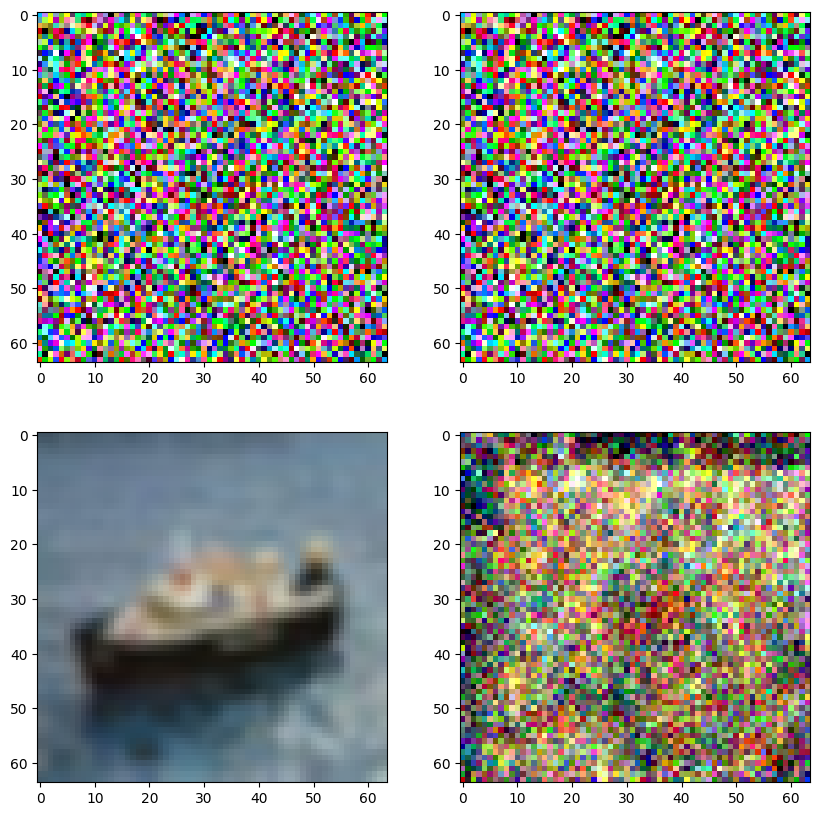

In [187]:
import random
idx = random.randint(0, len(testSet)-1)
x_t, epsilon, t = testSet.__getitem__(idx, t=800)
t = t.unsqueeze(0)
with torch.no_grad():
    output = model(x_t.unsqueeze(0).to(device), t.to(device))[0]
fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2, 2, figsize=(10, 10))
ax1.imshow(cifar.renormalize(x_t[:3]))
ax2.imshow(cifar.renormalize(epsilon))
x_0_recons = x_t[:3] / torch.sqrt(dp.alphas_tilde[t]) - torch.sqrt(1 - dp.alphas_tilde[t]) * epsilon / torch.sqrt(dp.alphas_tilde[t])
x_0_recons = cifar.renormalize(x_0_recons)
ax3.imshow(x_0_recons)
x_0_pred = x_t[:3] / torch.sqrt(dp.alphas_tilde[t]) - torch.sqrt(1 - dp.alphas_tilde[t]) * output.to('cpu') / torch.sqrt(dp.alphas_tilde[t])
x_0_pred = cifar.renormalize(x_0_pred)
ax4.imshow(x_0_pred)


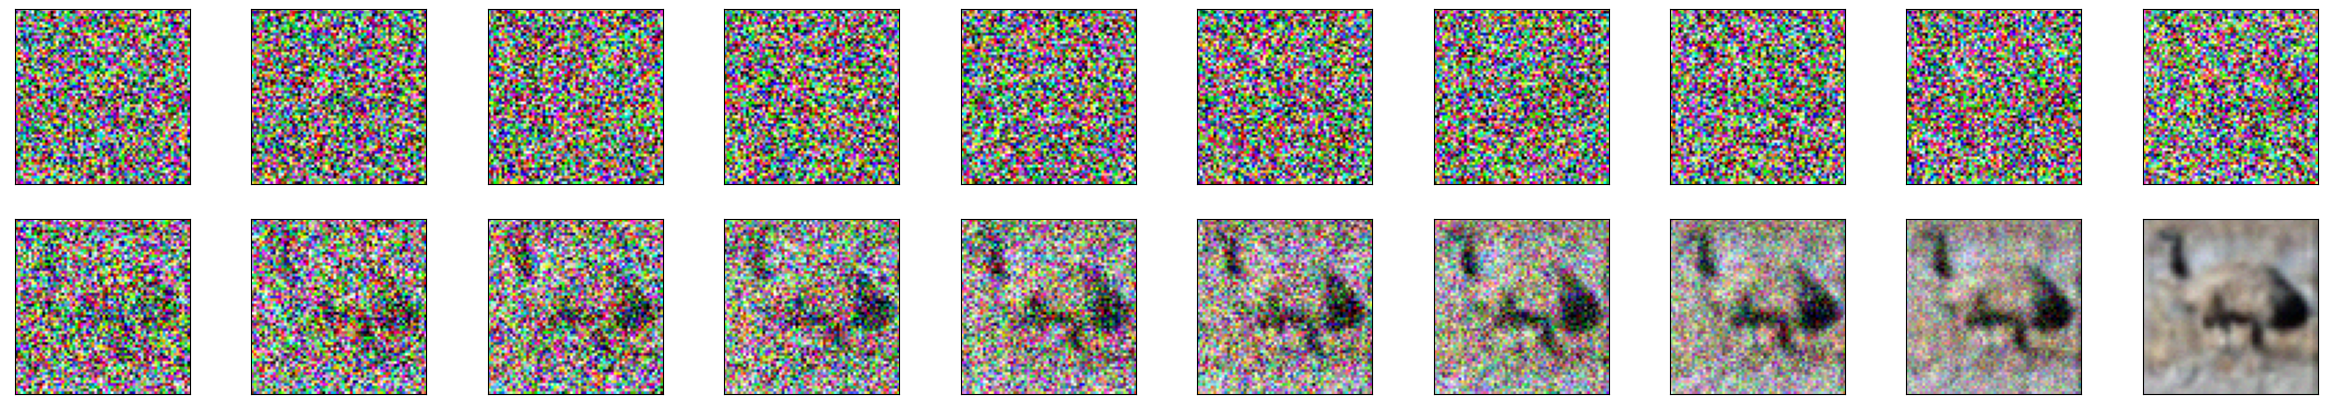

In [167]:
snapshots = [cifar.renormalize(testSet.__getitem__(idx, t=i*50)[0]) for i in range(1000//50)]
snapshots.reverse()
fig, axes  = plt.subplots(2, len(snapshots)//2, figsize=(30, 5))
for j, row in enumerate(axes):
    for i, ax in enumerate(row):
        k = i + j * len(snapshots)//2
        ax.imshow(torch.clip(snapshots[k], 0, 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Diffusion denoising


In [256]:
from tqdm.notebook import tqdm
# idx = random.randint(0, len(testSet)-1)
x_t, _, _ = testSet.__getitem__(idx, t=299)


snapshots = []
with torch.no_grad():
    for t in tqdm(reversed(range(1, 300))):
        t = torch.tensor(t)
        output = model(x_t.unsqueeze(0).to(device), t.unsqueeze(0).to(device))[0]
        x_t = dp.reverse_process(x_t, t, output)
        if t % 50 == 0:
            snapshots.append(cifar.renormalize(x_t))

    snapshots.append(cifar.renormalize(x_t))

0it [00:00, ?it/s]

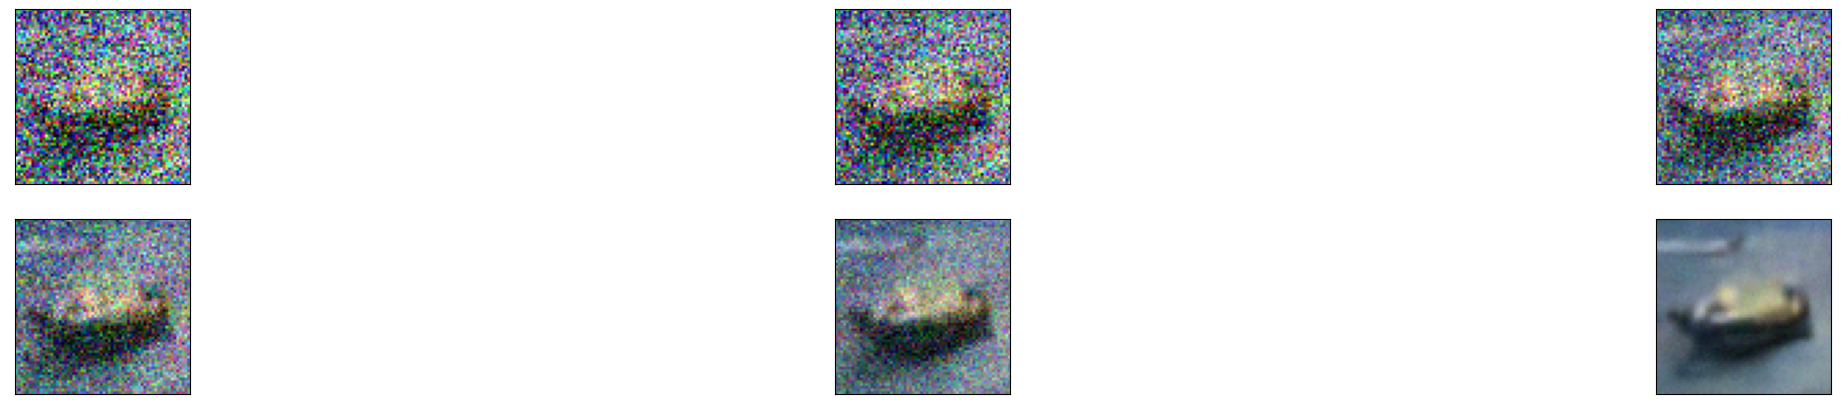

In [257]:
fig, axes  = plt.subplots(2, len(snapshots)//2, figsize=(30, 5))
for j, row in enumerate(axes):
    for i, ax in enumerate(row):
        k = i + j * len(snapshots)//2
        ax.imshow(torch.clip(snapshots[k], 0, 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Fast inference

In [262]:
def reverse_process2(x_t, x_0, t, t_new, output):
    x_0_pred = (x_t - torch.sqrt(1 - dp.alphas_tilde[t]) * output.to('cpu')) / torch.sqrt(dp.alphas_tilde[t])
    mean = x_0_pred * torch.sqrt(dp.alphas_tilde[t-1]) * dp.betas[t] / (1 - dp.alphas_tilde[t])
    mean += x_t * torch.sqrt(dp.alphas[t]) * (1 - dp.alphas_tilde[t-1]) / (1 - dp.alphas_tilde[t])
    beta_tilde = dp.betas[t] * (1 - dp.alphas_tilde[t - 1]) / (1 - dp.alphas_tilde[t])
                             
    return mean + torch.sqrt(beta_tilde) * torch.randn_like(mean)

from tqdm.notebook import tqdm
# idx = random.randint(0, len(testSet)-1)
x_t, _, _ = testSet.__getitem__(idx, t=299)


snapshots = []
x_0_preds = []
with torch.no_grad():
    for t in tqdm(reversed(range(1, 300))):
        t = torch.tensor(t)
        output = model(x_t.unsqueeze(0).to(device), t.unsqueeze(0).to(device))[0]
        x_0_pred = (x_t - torch.sqrt(1 - dp.alphas_tilde[t]) * output.to('cpu')) / torch.sqrt(dp.alphas_tilde[t])
        x_0_preds.append(cifar.renormalize(x_0_pred))
        x_t = reverse_process2(x_t, x_0_pred, t, t-1, output)
        snapshots.append(cifar.renormalize(x_t))

    snapshots.append(cifar.renormalize(x_t))
    x_0_preds.append(cifar.renormalize(x_0_pred))

0it [00:00, ?it/s]

In [263]:
x_0_preds = x_0_preds[::50]
snapshots = snapshots[::50]

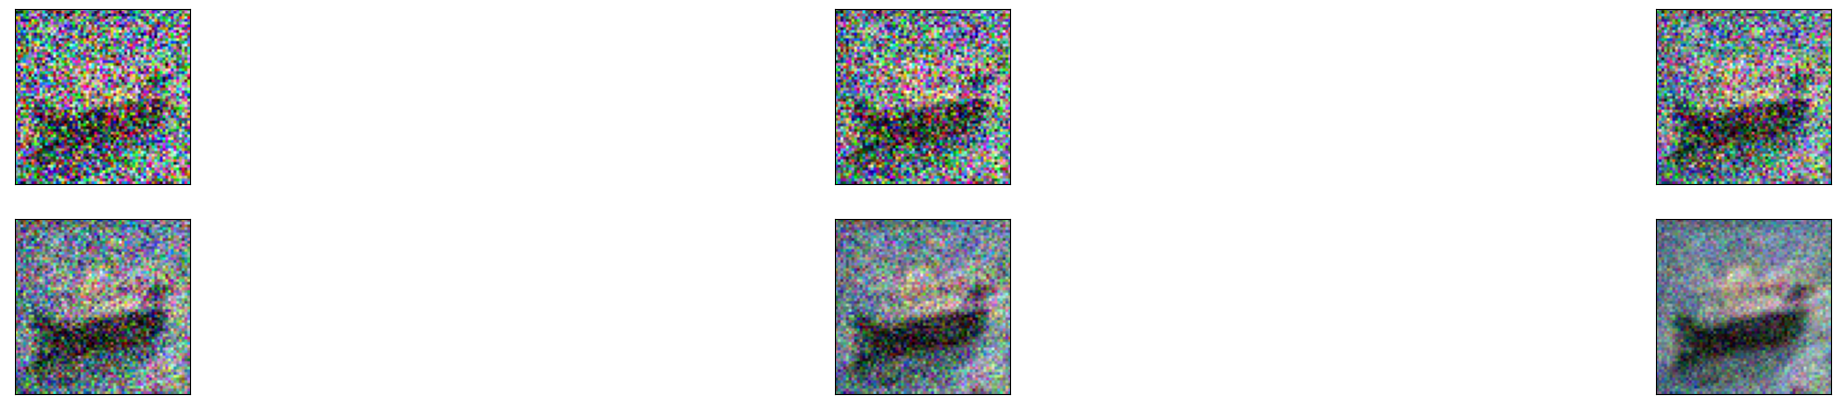

In [264]:

fig, axes  = plt.subplots(2, len(snapshots)//2, figsize=(30, 5))
for j, row in enumerate(axes):
    for i, ax in enumerate(row):
        k = i + j * len(snapshots)//2
        ax.imshow(torch.clip(snapshots[k], 0, 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

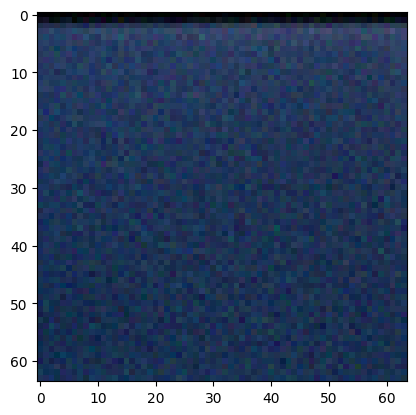

In [240]:
t = torch.tensor(10)
output = model(x_t.unsqueeze(0).to(device), t.unsqueeze(0).to(device))[0]
x_0_pred = (x_t - torch.sqrt(1 - dp.alphas_tilde[t]) * output.to('cpu')) / torch.sqrt(dp.alphas_tilde[t])
plt.imshow(cifar.renormalize(x_0_pred).detach())